In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import sys
from normalize_data import getNormalizedDataset

In [371]:
df = getNormalizedDataset()

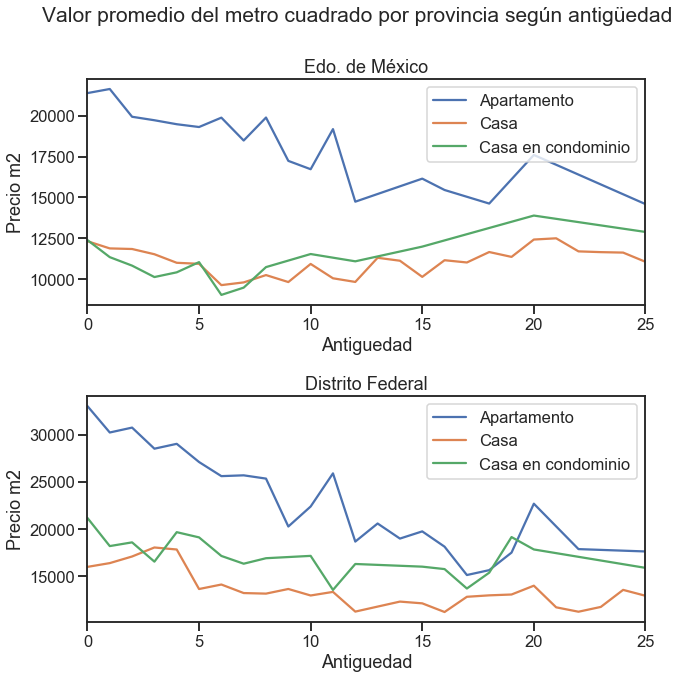

In [372]:
# Influye la antiguedad en el valor de las casas?
# Tomo datos agrupando por antiguedad, tipo de propiedad y provincia. 
# Filtro aquellos grupos donde la cantidad no es suficiente como para hacer un analisis consistente
# Armo un grafico para cada provincia, comparando los tipos de propiedad

df2 = df.copy()

df2 = df2[df2['extras']==2]

df2 = df2.groupby(['antiguedad','tipodepropiedad','provincia']).filter(lambda x: len(x)>10).groupby(['antiguedad','tipodepropiedad','provincia']).agg({'precio_m2':'mean'})

df2 = df2.reset_index()

df2.dropna(subset=['precio_m2'], inplace=True)

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según antigüedad',fontsize=21)

for name in ['Apartamento','Casa', 'Casa en condominio']:
    
    ax1.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].precio_m2,\
            label=name)
    ax1.set_title('Edo. de México')

    ax2.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].precio_m2,\
            label=name)
    ax2.set_title('Distrito Federal')

    ax1.set_xlim([0,25])
    ax2.set_xlim([0,25])

    
ax1.set_xlabel("Antiguedad")
ax1.set_ylabel("Precio m2")
ax1.legend(loc='best')
ax2.set_xlabel("Antiguedad")
ax2.set_ylabel("Precio m2")
ax2.legend(loc='best')


In [592]:
df.groupby('provincia').describe()['precio_m2']
#ciudad_promedio_preciom2_similar = ['Edo. de México','Guerrero','Jalisco','Nuevo León']


,count,mean,std,min,25%,50%,75%,max
provincia,,,,,,,,
Aguascalientes,1653.00,6983.63,3663.74,1300.05,4704.14,6562.50,8508.77,56666.67
Baja California Norte,3155.00,5855.64,4251.65,972.22,3941.17,4944.44,6583.33,112291.67
Baja California Sur,1660.00,6894.79,5136.60,987.65,3826.25,5750.00,8607.14,86333.33
Campeche,206.00,8763.43,12176.93,916.47,3819.37,6542.68,10412.50,121951.22
Chiapas,1054.00,9564.28,13079.51,1000.00,6070.04,8883.33,11198.51,396641.70
Chihuahua,4392.00,7350.64,8373.22,816.33,4310.34,6543.30,9200.00,455555.56
Coahuila,3568.00,6378.52,5329.99,900.00,4323.73,5882.35,7692.31,250000.00
Colima,946.00,7932.23,7628.44,1000.00,4074.07,6296.30,9333.33,133333.33
Distrito Federal,51026.00,20688.58,11694.48,875.00,12438.11,17785.71,26323.11,333333.33


In [373]:
# Del grafico anterior, se puede observar:
# En ambas ciudades, los precios de los apartamentos van disminuyendo, a la vez que aumenta la antiguedad
# En el caso de las casas, los precios parecen no verse afectados por la antiguedad, pudiendo tener menos o mas valor
# La diferencia de precios, parece verse mas evidente a partir de los 10 años de antiguedad, no asi en los primeros 5.
# No es un dato menor que vaya disminuyendo pero a la vez siga habiendo picos. Si bien es un dato que influye,
# pueden existir casas mas antiguas de mayor valor.

Text(0.5, 1.0, 'Valor del m2 segun tipo de propiedad y antiguedad \n')

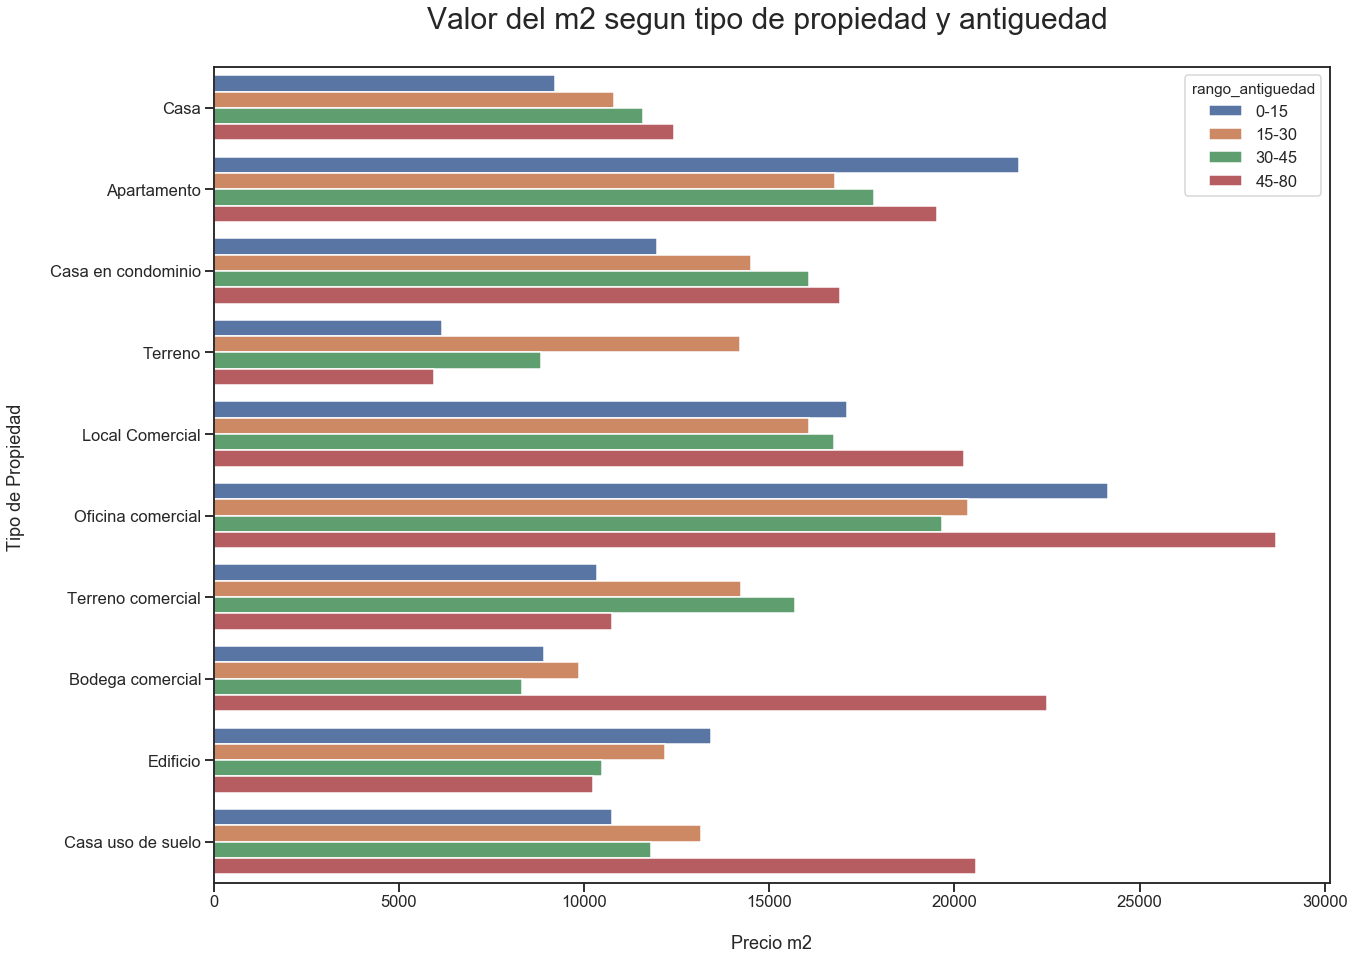

In [627]:
# Se tomn las 10 provincias con mas casas y los 20 tipos de propiedades mas comunes.
# Se evalua el precio del metro cuadrado para cada tipo de propiedad en una provincia distinta

df3 = df.copy()

df3['rango_antiguedad'] = pd.cut(df['antiguedad'],\
                                 bins=[-1,15,30,45,80],\
                                 labels=['0-15', '15-30', '30-45', '45-80'])

top_10_tipos_mas_comunes = df3.groupby('tipodepropiedad').size().sort_values(ascending=False)[0:10]
top_10_tipos_mas_comunes = list(top_10_tipos_mas_comunes.index)

plt.figure(figsize=(20,15))
data = df3.groupby(['rango_antiguedad','tipodepropiedad']).agg({'precio_m2':'mean'})
data = data.reset_index()

data = data.loc[data['tipodepropiedad'].isin(top_10_tipos_mas_comunes),:]

data.tipodepropiedad.cat.remove_unused_categories(inplace=True)

#pivot = data.pivot(index='tipodepropiedad', columns='rango_antiguedad', values='precio_m2')

mask = pivot.isnull()
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
#ax = sns.heatmap(pivot, cmap="YlGnBu")


ax = sns.barplot(data=data, y='tipodepropiedad', x='precio_m2', hue='rango_antiguedad', order=top_10_tipos_mas_comunes)

ax.set(xlabel='\n Precio m2 ', ylabel='Tipo de Propiedad \n')
ax.set_title('Valor del m2 segun tipo de propiedad y antiguedad \n', fontdict={'fontsize':30})

#ax.set_facecolor('xkcd:grey')


# De este grafico, se puede sacar como informacion:
# Los tres tipos de casas, tienden a incrementar levemente su valor.
# Los apartamentos, y los edificios, tienden a decrementar levemente su valor.
# El resto presentan un comportamiento irregular, del que es dificil predecir algo.

In [374]:
# Caracteristicas principales de agrupar por habitaciones
# Las casas de mas habitaciones, son mucho mas viejas
# No es algo muy importante, pero es un dato curioso
df.groupby('habitaciones').mean()

,antiguedad,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,precio_dolar,precio_m2,extras
habitaciones,,,,,,,,,,,,,,
0.00,0.00,0.00,0.00,40.00,40.00,0.00,0.00,0.00,0.00,0.00,500000.00,25588.54,12500.00,0.00
1.00,6.05,0.76,1.19,84.89,116.23,0.11,0.07,0.12,0.38,0.36,1680159.58,85985.65,20078.25,1.06
1.20,3.81,0.53,1.41,228.40,255.47,0.00,0.00,0.00,0.26,0.28,2098470.47,107393.58,12314.92,0.53
1.33,11.59,0.23,1.56,80.45,93.14,0.00,0.00,0.00,0.23,0.36,1656184.55,84758.68,28033.03,0.23
1.44,0.20,0.01,1.37,21.05,289.67,0.00,0.00,0.05,0.32,0.18,1039581.92,53202.76,10713.58,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8.00,13.90,0.84,2.62,270.51,285.86,0.01,0.01,0.03,0.42,0.34,2626539.20,134418.59,9897.65,0.89
8.25,21.00,0.80,2.90,303.80,307.00,0.00,0.00,0.00,0.40,0.40,3970000.00,203172.98,13476.04,0.80
9.00,15.10,0.85,2.46,277.85,294.61,0.01,0.02,0.01,0.40,0.37,2557393.56,130879.92,9639.35,0.90


In [375]:
# Cantidad de tipos de propiedades
df.tipodepropiedad.value_counts()

Casa                             129110
Apartamento                       53594
Casa en condominio                17719
Terreno                            9011
Local Comercial                    2570
Oficina comercial                  1555
Terreno comercial                  1190
Bodega comercial                   1046
Edificio                            686
Casa uso de suelo                   576
Quinta Vacacional                   372
Villa                               316
Duplex                              295
Rancho                              166
Inmuebles productivos urbanos       156
Local en centro comercial           148
Departamento Compartido             131
Otros                                82
Nave industrial                      61
Terreno industrial                   21
Huerta                               20
Hospedaje                             1
Garage                                1
Lote                                  0
Name: tipodepropiedad, dtype: int64

In [379]:
# Provincias mas grandes
df.groupby(['ciudad']).size().sort_values()[-10:]

ciudad
Atizapán de Zaragoza     5033
Alvaro Obregón           5231
Naucalpan de Juárez      5464
Cuauhtémoc               5820
Monterrey                6178
Mérida                   6832
San Luis Potosí          7163
Zapopan                  9490
Benito Juárez           10058
Querétaro               12116
dtype: int64

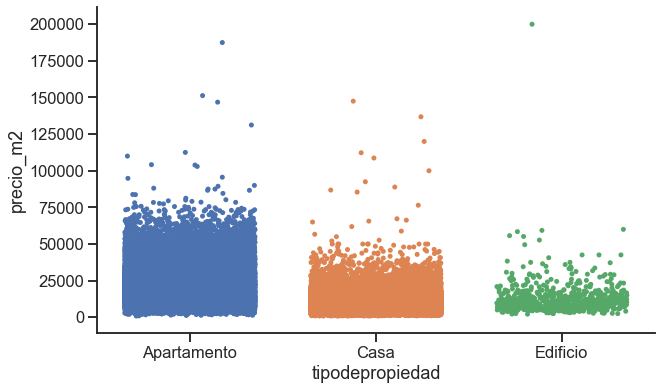

In [380]:

plt.figure(figsize=(10, 6))

sns.set(style='ticks', context='talk')

sns.stripplot(x='tipodepropiedad', y='precio_m2', data=df, order=['Apartamento','Casa','Edificio'], jitter=0.35)
sns.despine()

ANALISIS POR CIUDAD Y/O PROVINCIA

In [617]:
df_ciudades = df.groupby(['ciudad','tipodepropiedad']).agg({'precio_m2':'mean'})
df_ciudades

precio_m2
ciudad    tipodepropiedad              
Abalá     Apartamento               nan
          Bodega comercial          nan
          Casa                      nan
          Casa en condominio        nan
          Casa uso de suelo         nan
...                                 ...
ZirAndaro Terreno comercial         nan
          Terreno industrial        nan
          Villa                     nan
          Hospedaje                 nan
          Garage                    nan

[21000 rows x 1 columns]

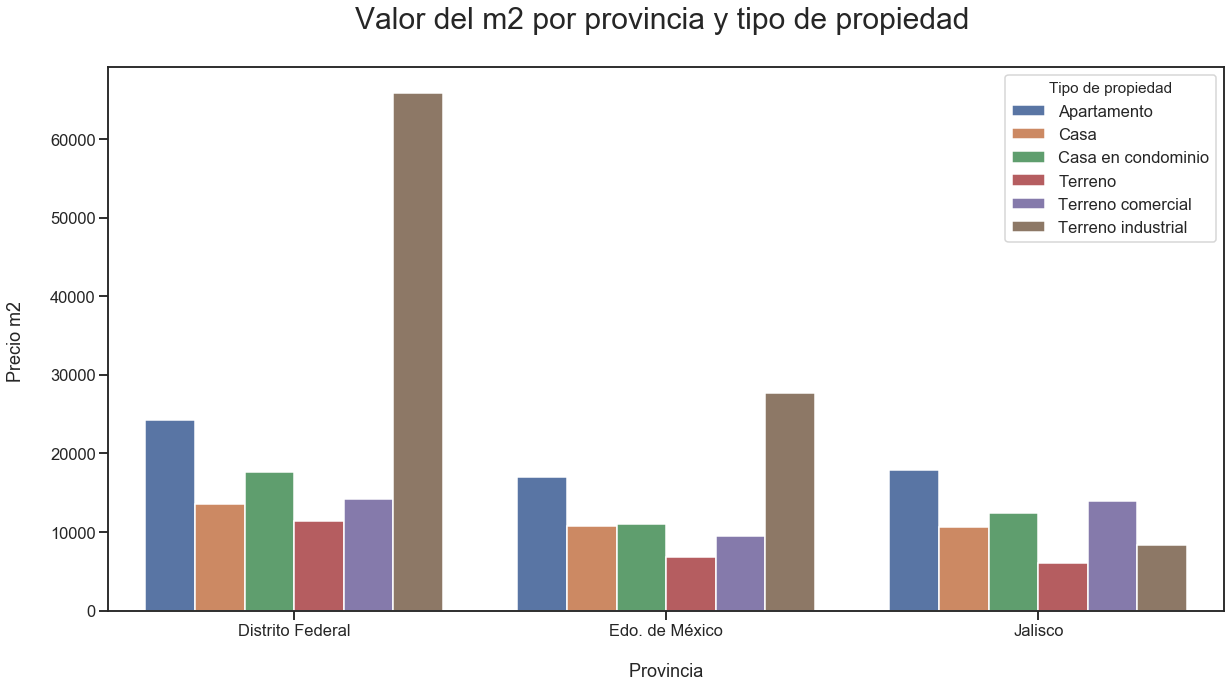

In [626]:
top_3_provincias_mas_pobladas = df.groupby('provincia').size().sort_values(ascending=False)[0:3]
top_3_provincias_mas_pobladas = list(top_3_provincias_mas_pobladas.index)
plt.figure(figsize=(20, 10))

df_provincias = df.groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})

df_provincias = df_provincias.reset_index()

df_provincias = df_provincias.loc[df_provincias['tipodepropiedad'].isin(['Apartamento','Casa','Casa en condominio','Terreno','Terreno comercial','Terreno industrial']), :]
df_provincias.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_provincias.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_provincias, x='provincia', y='precio_m2', hue='Tipo de propiedad', order=top_3_provincias_mas_pobladas)

ax.set(xlabel='\n Provincia ', ylabel='Precio m2 \n')
ax.set_title('Valor del m2 por provincia y tipo de propiedad \n', fontdict={'fontsize':30})
plt.show()


# Este grafico esta de mas ya qe dice lo mismo que el de abajo. Deberia hacer alguno con las ciudades


Text(0.5, 1, 'Valor del m2 segun tipo de propiedad y provincia \n')

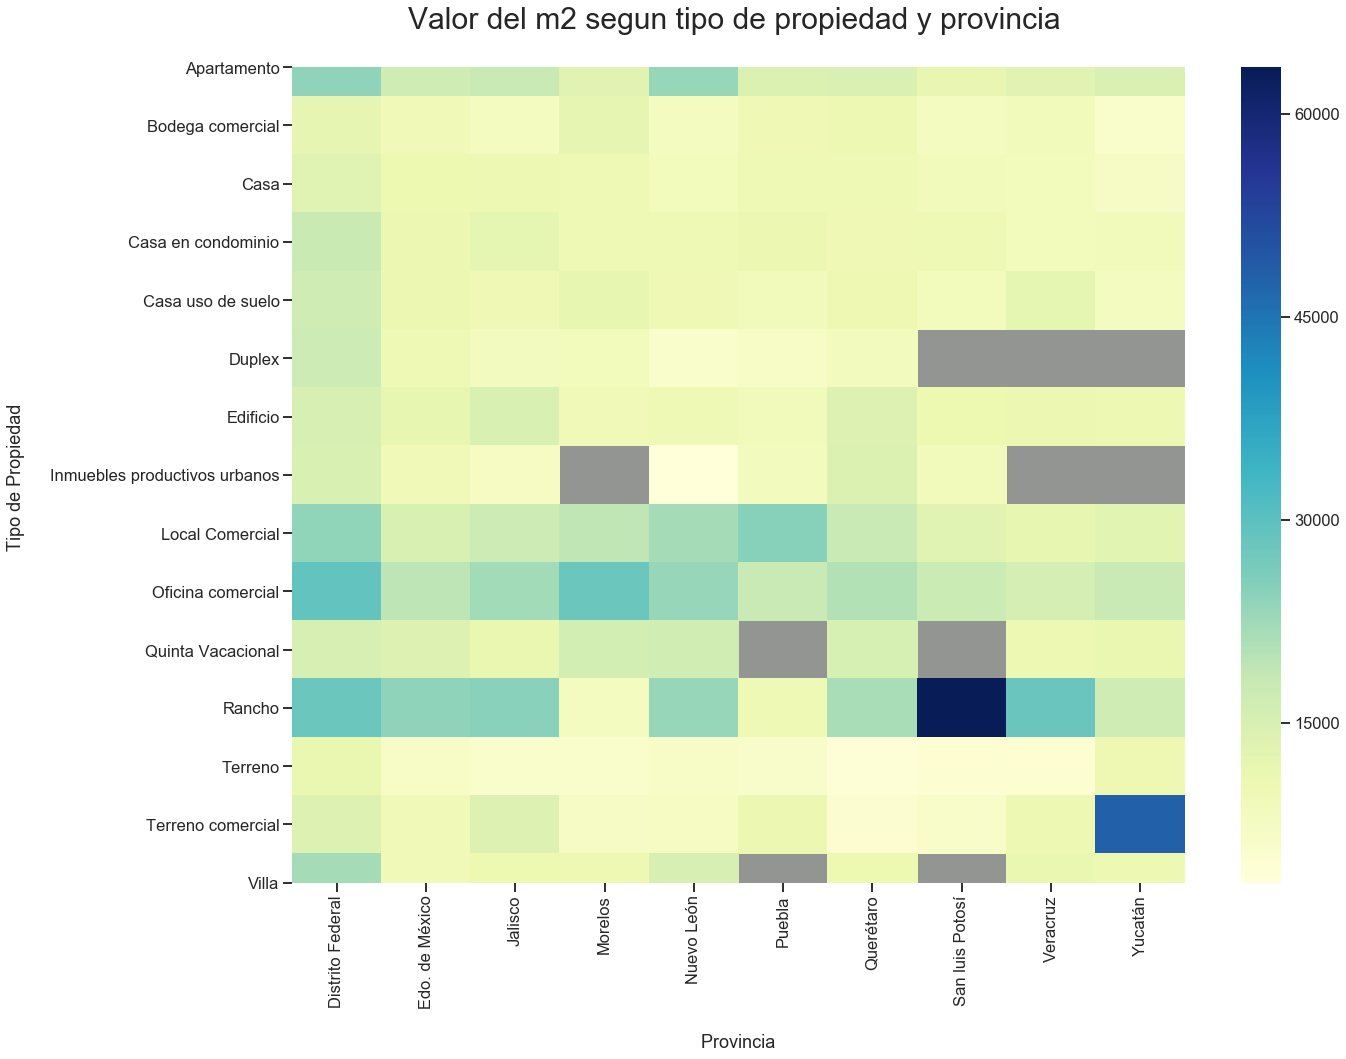

In [606]:
# Se tomn las 10 provincias con mas casas y los 20 tipos de propiedades mas comunes.
# Se evalua el precio del metro cuadrado para cada tipo de propiedad en una provincia distinta

top_10_provincias_mas_pobladas = df.groupby('provincia').size().sort_values(ascending=False)[0:10]
top_10_provincias_mas_pobladas = list(top_10_provincias_mas_pobladas.index)

top_15_tipos_mas_comunes = df.groupby('tipodepropiedad').size().sort_values(ascending=False)[0:15]
top_15_tipos_mas_comunes = list(top_15_tipos_mas_comunes.index)

plt.figure(figsize=(20,15))
data = df.groupby(['provincia','tipodepropiedad']).filter(lambda x: len(x)>1).groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})
data = data.reset_index()

data = data.loc[data['provincia'].isin(top_10_provincias_mas_pobladas),:]
data = data.loc[data['tipodepropiedad'].isin(top_15_tipos_mas_comunes),:]

data.tipodepropiedad.cat.remove_unused_categories(inplace=True)
data.provincia.cat.remove_unused_categories(inplace=True)

pivot = data.pivot(index='tipodepropiedad', columns='provincia', values='precio_m2')

mask = pivot.isnull()
#cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
ax = sns.heatmap(pivot, cmap="YlGnBu")
ax.set_facecolor('xkcd:grey')
ax.set(xlabel='\n Provincia ', ylabel='Tipo de Propiedad \n')
ax.set_title('Valor del m2 segun tipo de propiedad y provincia \n', fontdict={'fontsize':30})

# Los grises, son missing values

# Este heatmap revela mucha informacion:
# Ranchos, oficinas y locales, son los mas caros
# Los apartamentos, son mas caros que las casas (raro)
# Distrito Federal, es mas caro que el resto
# Ademas, permite ver la variacion del precio segun el lugar y el tipo.
# Dudas. Esta bien dejar los missing values? o deberia sacar esas categorias?
# Podria mostrar mas informacion, pero los missing values crecen considerablemente

In [384]:
len(list(df['tipodepropiedad'].value_counts().index))

24

In [385]:
df.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio',
       'precio_dolar', 'precio_m2', 'extras'],
      dtype='object')

In [408]:
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year

In [387]:
df.groupby(['año','mes']).size()

año   mes
2012  1       1448
      2       1271
      3       1042
      4       1342
      5       1768
      6       1456
      7       1827
      8       3705
      9       2404
      10      2838
      11      1500
      12      1373
2013  1       1873
      2       1298
      3       1602
      4       1693
      5       1859
      6       1862
      7       2350
      8       2210
      9       3091
      10      3697
      11      3708
      12      2913
2014  1       2195
      2       2300
      3       2692
      4       2588
      5       2873
      6       2832
      7       2901
      8       3301
      9       3649
      10      3529
      11      4302
      12      4214
2015  1       3987
      2       3614
      3       3630
      4       3491
      5       3368
      6       3445
      7       3489
      8       4156
      9       4412
      10      5038
      11      4456
      12      3938
2016  1       5228
      2       4165
      3       4521
      4       5979
  

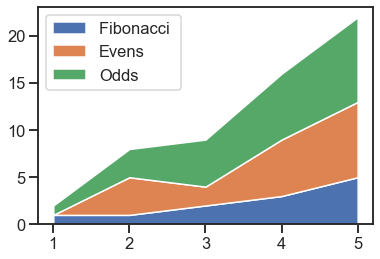

In [388]:
# Ya se me va a ocurrir algo con el diagrama de area

x = [1, 2, 3, 4, 5]
y1 = [1, 1, 2, 3, 5]
y2 = [0, 4, 2, 6, 8]
y3 = [1, 3, 5, 7, 9]

y = np.vstack([y1, y2, y3])

labels = ["Fibonacci ", "Evens", "Odds"]

fig, ax = plt.subplots()
ax.stackplot(x, y1, y2, y3, labels=labels)
ax.legend(loc='upper left')
plt.show()


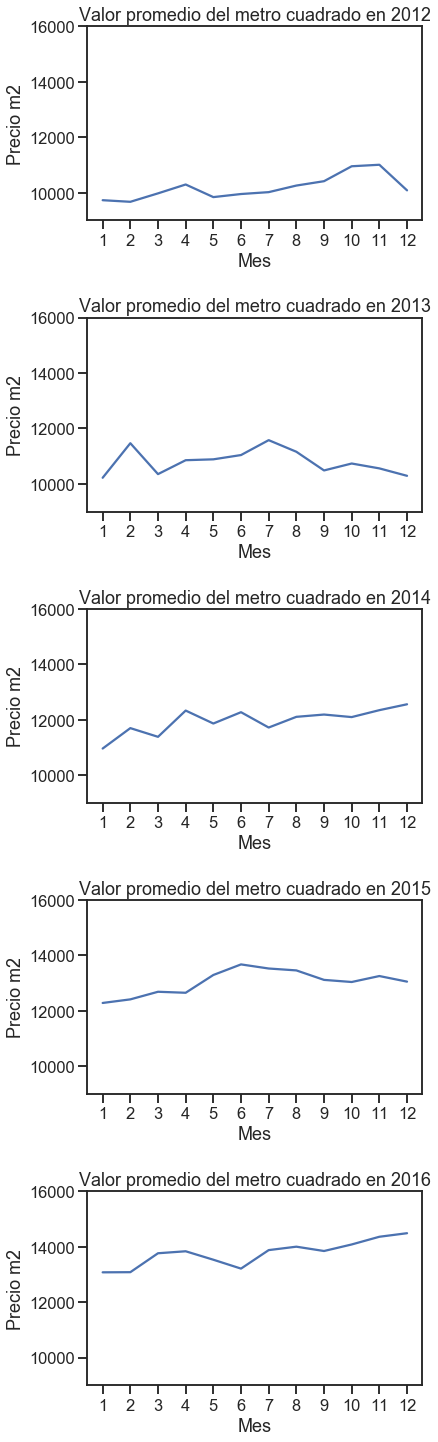

In [521]:
# Como fue variando el precio del metro cuadrado en pesos mexicanos a lo largo de los años?
df2 = df.copy()
df2 = df2.groupby(['año','mes']).agg({'precio_m2':'mean'})
df2 = df2.reset_index()

fig,ax1 = plt.subplots(5,1, figsize=(6,25))
i = 0
plt.setp(ax1, xticks=[1,2,3,4,5,6,7,8,9,10,11,12])
fig.subplots_adjust(hspace=0.5)

for año in [2012,2013,2014,2015,2016]: 
    ax1[i].set_xlabel("Mes")
    ax1[i].set_ylabel("Precio m2")
    ax1[i].plot(df2[(df2.año==año)].mes,\
            df2[(df2.año==año)].precio_m2,\
            label=name)
    ax1[i].set_title('Valor promedio del metro cuadrado en {}'.format(año))
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    ax1[i].set_ylim([9000,16000])
    i += 1

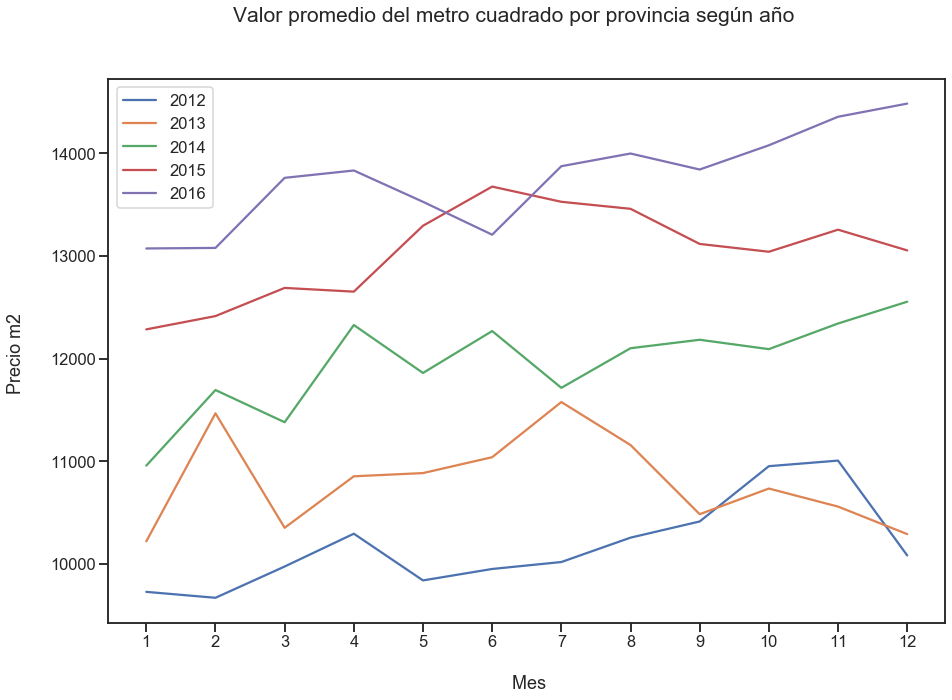

In [490]:
# Como fue variando el precio del metro cuadrado en pesos mexicanos a lo largo de los años?

df2 = df.copy()

df2 = df2.groupby(['año','mes']).agg({'precio_m2':'mean'})

df2 = df2.reset_index()

fig,ax1 = plt.subplots(1,1, figsize=(15,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según año',fontsize=21)

for año in [2012,2013,2014,2015,2016]:
    
    ax1.plot(df2[(df2.año==año)].mes,\
            df2[(df2.año==año)].precio_m2,\
            label=año)

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])    
ax1.set_xlabel("\n Mes")
ax1.set_ylabel("Precio m2 \n")
ax1.legend(loc='best')


# De este grafico se observa:
# Este grafico son todos los anteriores juntos.
# Las 5 lineas, respectivas a cada año, son casi paralelas, y salvo 2013 (se mantiene), todas incrementan.
# Esto nos da la pauta de que año a año los valores de las propiedades, van subiendo.

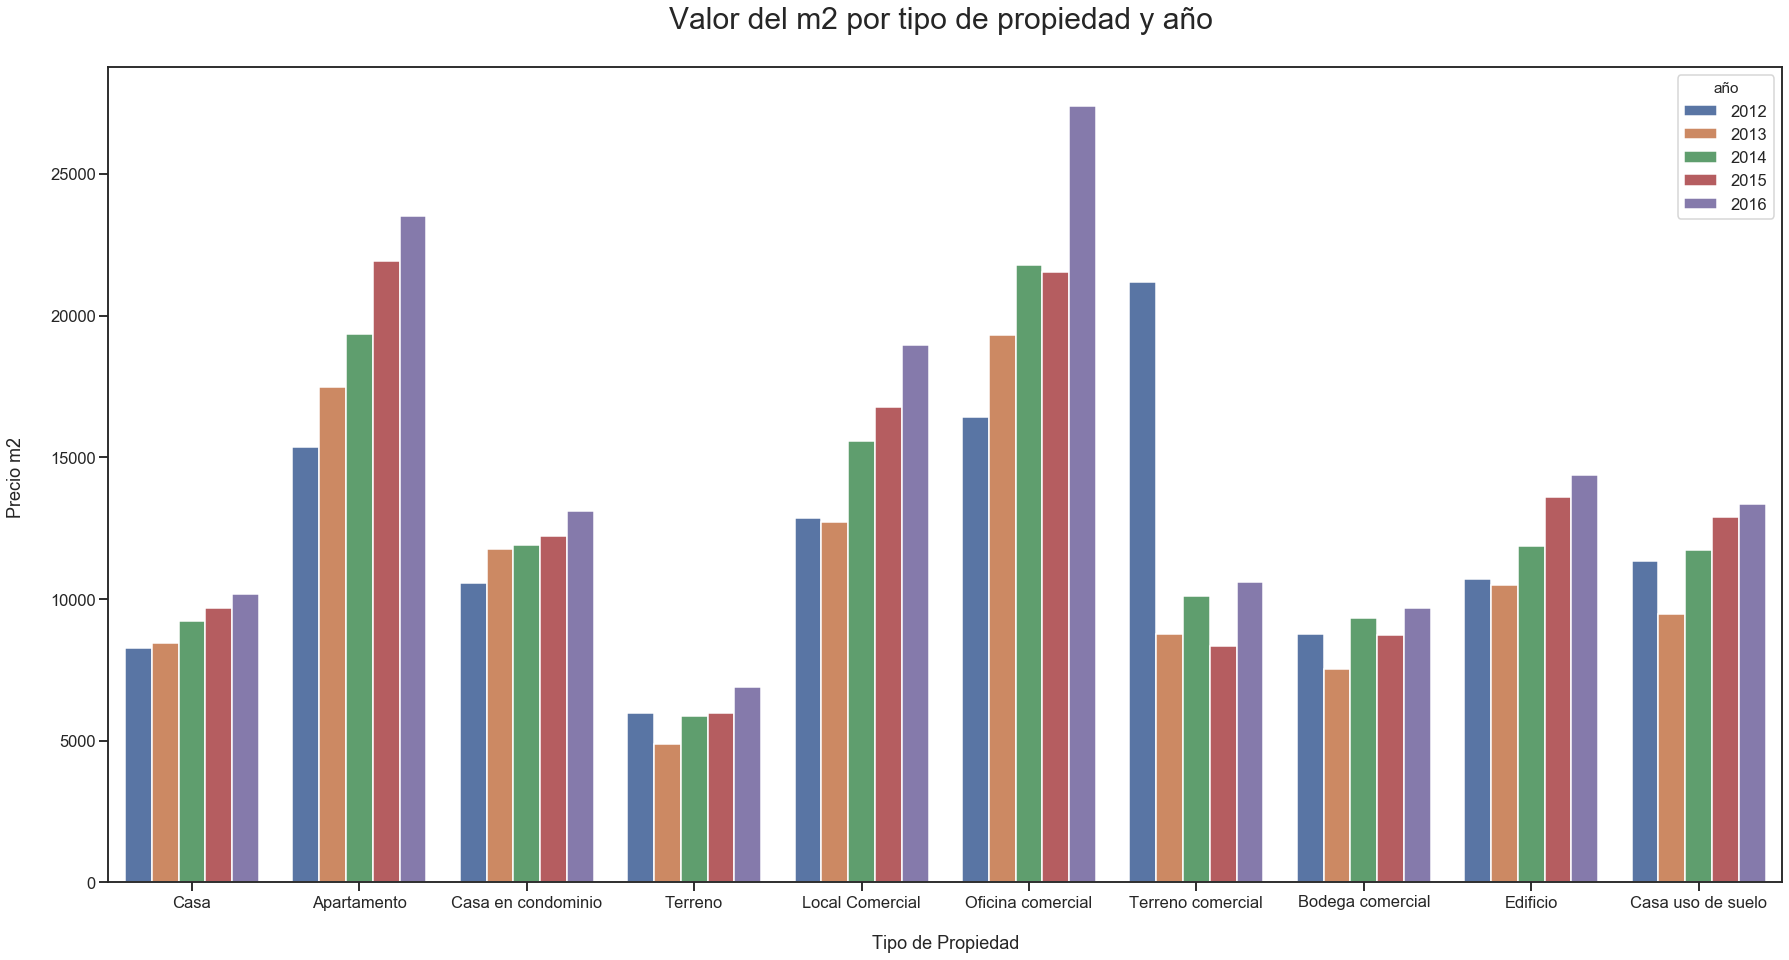

In [520]:
# Y si tomo en cuenta los tipos de propiedades. Todas fueron subiendo de precio? O como se comportaron?
# Filtro para asegurarme de que los grupos que tomo sean de mas de 20 casas

df_años = df.groupby(['año','tipodepropiedad']).filter(lambda x: len(x)>20).groupby(['año','tipodepropiedad']).agg({'precio_m2':'mean'})
top_5_tipos_mas_comunes = df.groupby('tipodepropiedad').size().sort_values(ascending=False)[0:10]
top_5_tipos_mas_comunes = list(top_5_tipos_mas_comunes.index)
plt.figure(figsize=(30, 15))

df_años = df_años.reset_index()

df_años = df_años.loc[df_años['tipodepropiedad'].isin(top_5_tipos_mas_comunes), :]
df_años.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_años.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_años, x='Tipo de propiedad', y='precio_m2', hue='año', order=top_5_tipos_mas_comunes)

ax.set(xlabel='\n Tipo de Propiedad ', ylabel='Precio m2 \n')
ax.set_title('Valor del m2 por tipo de propiedad y año \n', fontdict={'fontsize':30})
plt.show()

# El grafico muestra, para cada tipo de propiedad y para cada año, como fue variando el precio.
# En todos los casos sube, a excepcion del Terreno Comercial, que, por alguna razon que desconozco, en 2012
# tenia un valor altisimo. Esta anomalía quizas es algo para mirar detenidamente.

# Quizas esto es algo que podriamos ver si, en dolares, tambien subio. Porque puede que sea simplemente por la inflacion
# del peso mexicano
